# Fuel Price Modelling

This notebook runs through the code used to select the best model to predict future petrol prices

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
import pickle
import math
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from itertools import chain
from itertools import combinations
from itertools import product
register_matplotlib_converters()

# Constants
CURRENT_LOCATION = (-33.9693, 151.0697)

# Get data
all_data = pd.read_csv('data/interim/all_data_cleaned.csv')
all_data['last_updated'] = pd.to_datetime(all_data['last_updated'], format='%Y-%m-%d %H:%M:%S')

# Data preprocessing - functions for generating features custom features
def new_month_radial_basis(x, m=1, cycle=30.4375, alpha=100):
    diff = min(x-m, cycle - x + m)
    return np.mod(np.exp(-1/(2*alpha)*(diff)**2), cycle, dtype=np.float32)

def new_year_radial_basis(x, m=1, cycle=365.25, alpha=100):
    diff = min(x-m, cycle - x + m)
    return np.mod(np.exp(-1/(2*alpha)*(diff)**2), cycle, dtype=np.float32)

def idxmax(series, window):
    """
    For each value in `series`, look at the past `window` values. It finds which row had the 
    maximum value and returns the index of that value.
    """
    i = 0
    while i + window <= len(series):
        yield(series.iloc[i:i+window].idxmax())
        i += 1
        
def idxmin_centre(series, window):
    """
    For each value in `series`, look at the past `window` values. It finds which row had the 
    maximum value and returns the index of that value.
    """
    half_window = int(window/2)
    i = half_window
    while i + half_window <= len(series):
        yield(series.iloc[i-half_window:i+half_window].idxmin())
        i += 1
        
# Helper functions
def possible_selections(ss):
    """
    For a list containing n elements, returns all possible combinations of size m where m = 1, 2, ..., n
    """
    return list(chain(*map(lambda x: combinations(ss, x), range(0, len(ss) + 1))))

def train_test_split_by_time(X, y, test_size=0.1, **kwargs):
    """
    If the train-test split shouldn't be done randomly but rather it should be split with past and 
    future values then this function will split the data that way
    """
    if test_size < 1:
        train_size = 1 - test_size
        total_length = len(X)
        split = round(train_size*total_length)
        X_train = X.iloc[:split, :]
        X_test = X.iloc[split:, :]
        y_train = y.iloc[:split, :]
        y_test = y.iloc[split:, :]
        return X_train, X_test, y_train, y_test
    else:
        split = len(X) - test_size
        X_train = X.iloc[:split, :]
        X_test = X.iloc[split:, :]
        y_train = y.iloc[:split, :]
        y_test = y.iloc[split:, :]
        return X_train, X_test, y_train, y_test        

def weighted_average(column, weights):
    """
    Usage: df.groupby(groups).apply(weighted_average(column_to_aggregate, weights_to_use))
    """
    def inner(group):
        return (group[column] * group[weights]).sum() / group[weights].sum()
    inner.__name__ = 'wtd_avg'
    return inner

def distance_calculator(first, second):
    """
    Calculates the distance between the first point and the second point.
    First and second must be in the form of a tuple (x, y)
    The inputs should be in degrees as the function will convert it to radians
    Output is in kilometres
    """
    first = (math.radians(first[0]), math.radians(first[1]))
    second = (math.radians(second[0]), math.radians(second[1]))
    return 6371.01 * math.acos(math.sin(first[0])*math.sin(second[0]) + math.cos(first[0])*math.cos(second[0])*math.cos(first[1] - second[1]))

# Data preprocessing - set date frequency to daily
all_data['date'] = all_data['last_updated'].dt.round('D')

# Data preprocessing - calculate weights for distance
all_data['distance'] = all_data[['loc_latitude', 'loc_longitude']].apply(lambda x: distance_calculator(CURRENT_LOCATION, x), axis=1)
all_data['distance_weights'] = 1/all_data['distance']

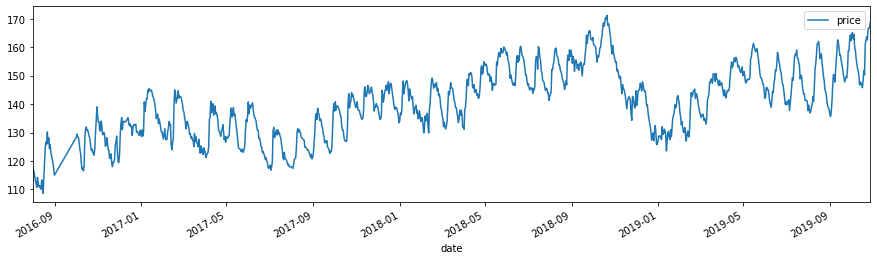

In [2]:
# Data visualised
all_data.pivot_table(index='date', values='price').plot(figsize=(15, 4));

In [3]:
# Parameters
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

class FuelPricePredictor:
    """
    List of additional features that can be used: new_month,
    new_year, days_since_last_max, days_since_last_max_sq
    """
    def __init__(self, library_model=LinearRegression, fuel_type='E10', lags=80,
                 predictions=60, test_size=0.1, train_test_split=train_test_split,
                 features=[], baseline=False, min_date='2000-01-01', max_date='2099-01-01',
                 sample=None, new_month_alpha=100, new_year_alpha=100, location_weights=False):
        self.library_model = library_model
        self.fuel_type = fuel_type
        self.lags = lags
        self.predictions = predictions
        self.test_size = test_size
        self.features = features
        self.baseline = baseline
        self.train_test_split = train_test_split
        self.min_date = min_date
        self.max_date = max_date
        self.sample = sample
        self.new_month_alpha = new_month_alpha
        self.new_year_alpha = new_year_alpha
        self.location_weights = location_weights

    def _generate_features(self, data):
        self.feature_labels = ['price'] + [f'price({-i})' for i in range(1, self.lags)]
        for i in range(1, self.lags):
            data[f'price(-{i})'] = data['price'].shift(i)
        if 'new_month' in self.features:
            self.feature_labels += ['new_month']
            data['new_month'] = data.index.day.map(lambda x: new_month_radial_basis(x, alpha=self.new_month_alpha))
        if 'new_year' in self.features:
            self.feature_labels += ['new_year']
            data['new_year'] = data.index.day.map(lambda x: new_year_radial_basis(x, alpha=self.new_year_alpha))
        if 'days_since_last_max' in self.features:
            self.feature_labels += ['days_since_last_max']
            window = 30
            data['last_max_date'] = pd.Series(idxmax(data['price'], window), index=data.index[window-1:])
            data['days_since_last_max'] = (data.index - data['last_max_date']).dt.days
        if 'days_since_last_max_sq' in self.features:
            self.feature_labels += ['days_since_last_max_sq']
            window = 30
            data['last_max_date'] = pd.Series(idxmax(data['price'], window), index=data.index[window-1:])
            data['days_since_last_max'] = (data.index - data['last_max_date']).dt.days
            data['days_since_last_max_sq'] = data['days_since_last_max']**2
        return data
            
    def _generate_targets(self, data):
        self.target_labels = [f'price({i})' for i in range(1, self.predictions+1)]
        for i in range(1, self.predictions+1):
            data[f'price({i})'] = data['price'].shift(-i)
        return data
    
    def fit(self, data):
        # Filter data by `fuel_type`
        data = data[data['fuel_type'] == self.fuel_type]
        
        # Select specific date range
        data = data[data['date'] > self.min_date]
        data = data[data['date'] < self.max_date]
        
        if self.location_weights:
            data = data.groupby('date').apply(weighted_average('price', 'distance_weights'))
            data = pd.DataFrame(data, columns=['price'])
        else:
            data = data.pivot_table(index='date', values='price', aggfunc='mean')
        self.data = data
            
        # Create features and targets
        data = self._generate_features(data)
        data = self._generate_targets(data)
        data = data.dropna(how='any')
        
        # Split data to training and test set
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split(data[self.feature_labels], data[self.target_labels], 
                                                                                     test_size=self.test_size, random_state=42, shuffle=True)
        
        # Resample if needed
        if self.sample:
            self.X_train = self.X_train.sample(int(len(self.X_train)*self.sample), random_state=40, replace=True)
            self.y_train = self.y_train.sample(int(len(self.y_train)*self.sample), random_state=40, replace=True)
        
        # Baseline model
        if self.baseline:
            self.y_preds = self.y_test.copy()
            for column in self.y_preds:
                self.y_preds.loc[:, column] = self.X_test.mean(axis=1)
            self.mean_square_error = ((self.y_preds - self.y_test)**2).mean(axis=1)**(1/2)
            self.mean_square_error = self.mean_square_error.mean()
        else:
            self.model = self.library_model()
            self.model.fit(self.X_train, self.y_train)
            self.y_preds = self.model.predict(self.X_test)
            self.y_preds = pd.DataFrame(self.y_preds, index=self.y_test.index, columns=self.y_test.columns)
        
        # Get residuals
        self.residuals = self.y_preds - self.y_test
        
        # Get test mean square error
        self.mean_square_error = ((self.y_preds - self.y_test)**2).mean(axis=1)**(1/2)
        self.mean_square_error = self.mean_square_error.mean()
    
    def predict(self, data, start_date='2016-01-01', end_date='2099-01-01', overlay_actuals=False, plot=False, minimum=False):
        # Prepare data
        data = data[data['fuel_type'] == self.fuel_type]
        data = data.pivot_table(index='date', values='price', aggfunc='mean')

        # Filter historical data within desired range
        plot_data = data[(data.index > start_date) & (data.index < end_date)]
        
        # Get prediction range
        last_date = plot_data.index.max()
        start_prediction_date = last_date + pd.Timedelta(1, 'D')
        predicted_date_range = pd.date_range(start=start_prediction_date, periods=self.predictions, freq='D')
        end_prediction_date = predicted_date_range.max()
        
        # Generate features
        formatted_data = self._generate_features(plot_data.copy())
        formatted_data = formatted_data.loc[:, self.feature_labels]
        formatted_data = formatted_data.dropna(how='any')
        
        # Get last row only
        formatted_data = formatted_data.iloc[[-1], :]
        self.formatted_data = formatted_data
        
        # Fit baseline model
        if self.baseline:
            mean = self.formatted_data.mean(axis=1).values[0]
            self.predicted_values = pd.DataFrame(index=predicted_date_range, columns=['price'])
            for date in self.predicted_values.index:
                self.predicted_values.loc[date, :] = mean
        else:
            # Output and format results
            self.predicted_values = self.model.predict(formatted_data)
            self.predicted_values = pd.DataFrame(self.predicted_values.flatten(), index=predicted_date_range, columns=['price'])

        # Plot results
        if plot:
            plt.figure(figsize=(12, 4))
            plt.plot(plot_data, label='Historical data')
            plt.plot(self.predicted_values, label='Predicted data')
            plt.xlabel('Date')
            plt.ylabel('Price (cents)')

        # Overlay actuals over the predicted values
        self.actuals = data.loc[(data.index >= start_prediction_date) & (data.index <= end_prediction_date), :]
        if plot and overlay_actuals:
            plt.plot(self.actuals, label='Actuals')
        
        # Indicate minimums
        if minimum:
            minimum_values = pd.Series(list(idxmin_centre(self.predicted_values['price'], window=20)))
            minimum_values = minimum_values.value_counts()
            minimum_values = minimum_values[minimum_values > 4]
            minimum_values = minimum_values.index
            minimum_values = model.predicted_values.loc[minimum_values, :]
            plt.scatter(minimum_values.index, minimum_values, c='red', alpha=0.8)
            for index, row in minimum_values.iterrows():
                date_as_string = pd.datetime.strftime(index, format='%d %B')
                print(f'On {date_as_string}, there will be a minimum price of {row[0]:,.2f} cents')
            
        # Put in a legend
        if plot:
            plt.legend(loc='lower left')
            
        # Development error
        self.dev_mean_square_error = ((self.predicted_values - self.actuals)**2).mean(axis=0)**(1/2)
        self.dev_mean_square_error = self.dev_mean_square_error.values[0]


Baseline model error is 8.757973700990972


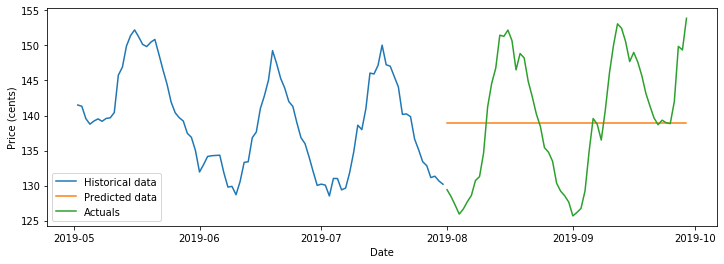

In [4]:
baseline_model = FuelPricePredictor(baseline=True)
baseline_model.fit(all_data)
baseline_model.predict(all_data, start_date='2019-05-01', end_date='2019-08-01', plot=True, overlay_actuals=True)
#plt.savefig('screenshots/baseline_model')
print('Baseline model error is', baseline_model.dev_mean_square_error)

In [53]:
# Write down all possible models to try out
params = {'library_model': [LinearRegression, Lasso],
          'test_size': [0.1, 0.2, 0.3, 0.4, 30, 60, 90, 120],
          'features': ['new_month', 'days_since_last_max', 'days_since_last_max_sq', 'new_year'],
          'train_test_split': [train_test_split, train_test_split_by_time],
          'min_date': ['2016-10-01', '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01', '2018-01-01', '2018-04-01', '2018-07-01'],
          'max_date': ['2019-07-01'],
          'sample': [1, 1.25, 1.5],
          'location_weights': [False],
          }

# Gets all possible combinations of features
if 'features' in params:
    unique_features = params['features']
    params['features'] = possible_selections(params['features'])

# Generate all combinations of parameters
keys = list(params)
possible_combinations = dict()
for values in product(*map(params.get, keys)):
    parameters = dict(zip(keys, values))
    possible_combinations[str(parameters)] = parameters
total_combinations = len(possible_combinations)
print(total_combinations, 'models to run')

12288 models to run


In [ ]:
# Iterate through each parameter combination
# Set to True to run through all possible models and save the models
if False:
    results = pd.DataFrame(columns=list(params) + ['mean_square_error', 'dev_mean_square_error'])
    for i, item in enumerate(possible_combinations.items()):
        key, value = item
        model = FuelPricePredictor(**value)
        model.fit(all_data)
        model.predict(all_data, end_date=value['max_date'])
        for column in results.columns:
            results.loc[key, column] = getattr(model, column)
        print(f'{i+1} out of {total_combinations}')
        
    # Save results to model pickle file if needed
    import pickle
    with open('results.pkl', 'wb') as f:
        pickle.dump(results, f)

In [102]:
# Get results from file if needed
if True:
    import pickle
    with open('results.pkl', 'rb') as f:
        results = pickle.load(f)

In [103]:
# Print the best performing models on the screen
results = results.loc[results['train_test_split'] == train_test_split_by_time, :]
results['evaluation'] = (results['dev_mean_square_error']**2 + results['mean_square_error']**2)**(1/2)
results = results.sort_values('evaluation')
results.head()

,library_model,test_size,features,train_test_split,min_date,max_date,sample,location_weights,mean_square_error,dev_mean_square_error,evaluation
"{'library_model': <class 'sklearn.linear_model.base.LinearRegression'>, 'test_size': 30, 'features': ('new_month', 'days_since_last_max_sq', 'new_year'), 'train_test_split': <function train_test_split_by_time at 0x000000000958DF28>, 'min_date': '2017-04-01', 'max_date': '2019-07-01', 'sample': 1.5, 'location_weights': False}",<class 'sklearn.linear_model.base.LinearRegres...,30,"(new_month, days_since_last_max_sq, new_year)",<function train_test_split_by_time at 0x000001...,2017-04-01,2019-07-01,1.5,False,6.03555,8.21616,10.1948
"{'library_model': <class 'sklearn.linear_model.base.LinearRegression'>, 'test_size': 30, 'features': ('new_month', 'days_since_last_max', 'days_since_last_max_sq', 'new_year'), 'train_test_split': <function train_test_split_by_time at 0x000000000958DF28>, 'min_date': '2017-04-01', 'max_date': '2019-07-01', 'sample': 1.5, 'location_weights': False}",<class 'sklearn.linear_model.base.LinearRegres...,30,"(new_month, days_since_last_max, days_since_la...",<function train_test_split_by_time at 0x000001...,2017-04-01,2019-07-01,1.5,False,6.03776,8.28378,10.2506
"{'library_model': <class 'sklearn.linear_model.base.LinearRegression'>, 'test_size': 30, 'features': ('new_month', 'days_since_last_max', 'new_year'), 'train_test_split': <function train_test_split_by_time at 0x000000000958DF28>, 'min_date': '2017-04-01', 'max_date': '2019-07-01', 'sample': 1.5, 'location_weights': False}",<class 'sklearn.linear_model.base.LinearRegres...,30,"(new_month, days_since_last_max, new_year)",<function train_test_split_by_time at 0x000001...,2017-04-01,2019-07-01,1.5,False,6.02192,8.32827,10.2773
"{'library_model': <class 'sklearn.linear_model.base.LinearRegression'>, 'test_size': 30, 'features': ('new_month', 'days_since_last_max_sq'), 'train_test_split': <function train_test_split_by_time at 0x000000000958DF28>, 'min_date': '2017-04-01', 'max_date': '2019-07-01', 'sample': 1.5, 'location_weights': False}",<class 'sklearn.linear_model.base.LinearRegres...,30,"(new_month, days_since_last_max_sq)",<function train_test_split_by_time at 0x000001...,2017-04-01,2019-07-01,1.5,False,6.12593,8.25698,10.2813
"{'library_model': <class 'sklearn.linear_model.base.LinearRegression'>, 'test_size': 30, 'features': ('new_month', 'days_since_last_max', 'days_since_last_max_sq', 'new_year'), 'train_test_split': <function train_test_split_by_time at 0x000000000958DF28>, 'min_date': '2017-01-01', 'max_date': '2019-07-01', 'sample': 1, 'location_weights': False}",<class 'sklearn.linear_model.base.LinearRegres...,30,"(new_month, days_since_last_max, days_since_la...",<function train_test_split_by_time at 0x000001...,2017-01-01,2019-07-01,1,False,6.16148,8.24898,10.2961


In [96]:
# Get model parameters that have the combined lowest dev error and test error
model_parameters = results.iloc[0, :]
print("Model's dev mean square error:", model_parameters['dev_mean_square_error'])
print("Model's mean square error:", model_parameters['mean_square_error'])
model_parameters = model_parameters.drop(['evaluation', 'mean_square_error', 'dev_mean_square_error'])
model_parameters = model_parameters.to_dict()

Model's dev mean square error: 8.216163985946626
Model's mean square error: 6.03554532536072


In [97]:
# Generate columns for features for mean square error plot
if 'features' in params:
    for feature in unique_features:
        results[feature] = results['features'].apply(lambda x: feature in x)
    print(unique_features)

['new_month', 'days_since_last_max', 'days_since_last_max_sq', 'new_year']


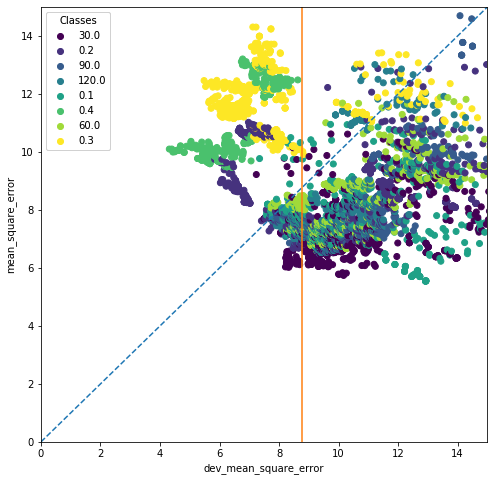

In [110]:
# Plot all models to get a sense of the mean square errors for each model - each dot represents one model
plot_data = results
fig, ax = plt.subplots(figsize=(8, 8))
column = 'test_size'
colours = pd.factorize(plot_data[column])[0]
scatter = ax.scatter(plot_data['dev_mean_square_error'], plot_data['mean_square_error'], 
                     c=colours)

ax.set_xlabel('dev_mean_square_error')
ax.set_ylabel('mean_square_error')
max_error = 15
ax.set_xlim((0, max_error))
ax.set_ylim((0, max_error))
ax.plot([0, max_error], [0, max_error], linestyle='dashed', label='45 degree line')
ax.plot([baseline_model.dev_mean_square_error, baseline_model.dev_mean_square_error], [0, max_error], label='Baseline dev MSE')
ax.legend()
leg = ax.legend(*scatter.legend_elements(), title="Classes")
[leg.get_texts()[i].set_text(label) for i, label in enumerate(pd.factorize(plot_data[column])[1])];
ax.add_artist(leg)

In [99]:
model_parameters

{'library_model': sklearn.linear_model.base.LinearRegression,
 'test_size': 30,
 'features': ('new_month', 'days_since_last_max_sq', 'new_year'),
 'train_test_split': <function __main__.train_test_split_by_time(X, y, test_size=0.1, **kwargs)>,
 'min_date': '2017-04-01',
 'max_date': '2019-07-01',
 'sample': 1.5,
 'location_weights': False}

On 01 September, there will be a minimum price of 130.87 cents
On 27 September, there will be a minimum price of 132.19 cents


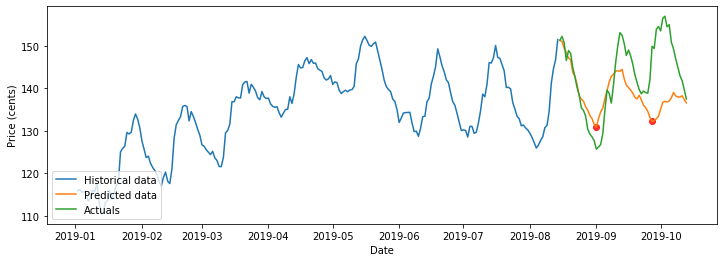

In [100]:
# Plot the predicted values against the validation set
model = FuelPricePredictor(**model_parameters)
model.fit(all_data)
model.predict(all_data, start_date='2019-01-01', end_date='2019-08-15', overlay_actuals=True, plot=True, minimum=True)
plt.savefig('screenshots/model_validation_predictions')

On 05 December, there will be a minimum price of 133.12 cents
On 10 November, there will be a minimum price of 135.95 cents


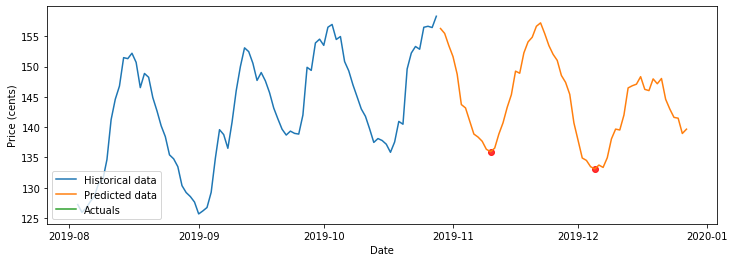

In [101]:
# Plot the predicted values against the future unknown data set
model = FuelPricePredictor(**model_parameters)
model.fit(all_data)
model.predict(all_data, start_date='2019-08-02', end_date='2019-10-30', overlay_actuals=True, plot=True, minimum=True)
plt.savefig('screenshots/model_future_predictions')

In [ ]:
### Appendix code

In [ ]:
dict(zip(range(len(model.feature_labels)), model.feature_labels))

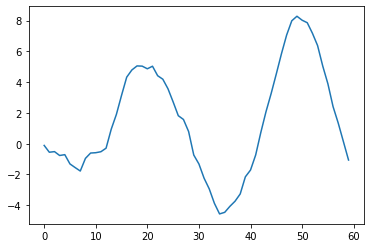

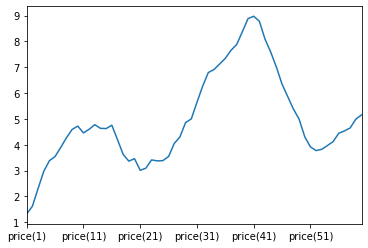

In [82]:
(model.y_preds - model.y_test).abs().mean(axis=0).plot()

(array([ 38., 101., 174., 292., 352., 391., 249., 138.,  54.,  11.]),
 array([-16.60801924, -13.22812612,  -9.848233  ,  -6.46833988,
         -3.08844676,   0.29144636,   3.67133948,   7.0512326 ,
         10.43112572,  13.81101884,  17.19091196]),
 <a list of 10 Patch objects>)

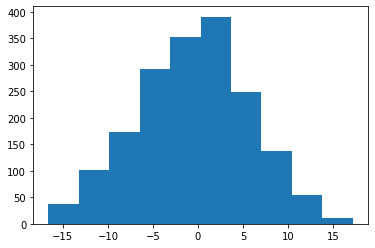

In [84]:
# Residual plot
plt.hist(model.residuals.values.flatten())

Text(0, 0.5, 'Actual')

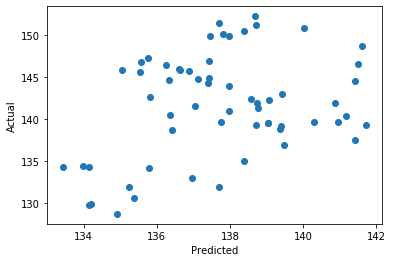

In [87]:
plt.scatter(model.y_preds.iloc[10, :], model.y_test.iloc[10, :])
plt.xlabel('Predicted')
plt.ylabel('Actual')

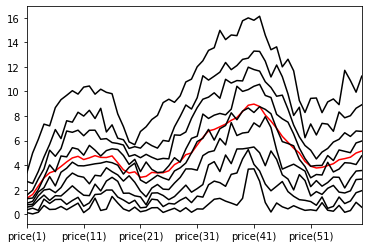

In [88]:
# Average predicted price deviation
(((model.y_preds - model.y_test)**2)**(1/2)).mean(axis=0).plot(color='red')
for i in np.linspace(0.05, 0.95, 9):
    (((model.y_preds - model.y_test)**2)**(1/2)).quantile(i, axis=0).plot(color='black')

In [89]:
(((model.y_preds - model.y_test)**2)**(1/2)).mean(axis=0)

price(1)     1.325349
price(2)     1.620742
price(3)     2.304882
price(4)     2.969505
price(5)     3.384618
price(6)     3.546582
price(7)     3.899421
price(8)     4.270721
price(9)     4.594206
price(10)    4.723725
price(11)    4.461167
price(12)    4.600782
price(13)    4.778755
price(14)    4.636811
price(15)    4.628493
price(16)    4.756943
price(17)    4.202706
price(18)    3.626914
price(19)    3.368122
price(20)    3.463573
price(21)    3.013629
price(22)    3.095432
price(23)    3.415030
price(24)    3.377234
price(25)    3.388128
price(26)    3.546372
price(27)    4.050946
price(28)    4.304399
price(29)    4.860684
price(30)    5.000454
price(31)    5.640921
price(32)    6.263749
price(33)    6.795332
price(34)    6.912813
price(35)    7.127867
price(36)    7.346335
price(37)    7.656224
price(38)    7.880466
price(39)    8.373186
price(40)    8.882364
price(41)    8.975465
price(42)    8.782955
price(43)    8.086966
price(44)    7.589478
price(45)    7.008604
price(46) 

6.246035387905012
11.660662339335339


<Figure size 864x216 with 0 Axes>

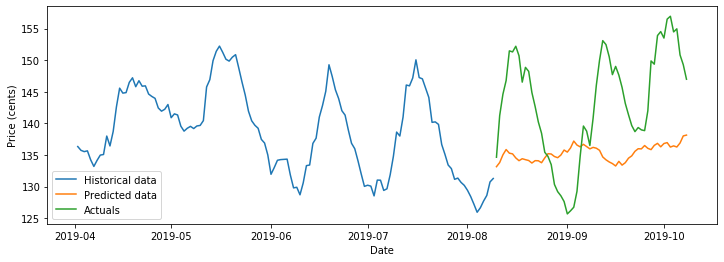

In [93]:
# Train a single model
model_parameters = {'library_model': sklearn.linear_model.base.LinearRegression,
                    'test_size': 10,
                    'features': ['new_month', 'new_year', 'days_since_last_max'],
                    'train_test_split': train_test_split_by_time,
                    'min_date': '2016-01-01',
                    'max_date': '2018-11-01',
                    'predictions': 60}
plt.figure(figsize=(12, 3))
model = FuelPricePredictor(**model_parameters)
model.fit(all_data)
model.predict(all_data, start_date='2019-04-01', end_date='2019-08-10', plot=True, overlay_actuals=True)
print(model.mean_square_error)
print(model.dev_mean_square_error)